## Predicting the price of Bitcoin with multivariate Pytorch LSTMs
- https://charlieoneill.medium.com/predicting-the-price-of-bitcoin-with-multivariate-pytorch-lstms-695bc294130

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023.6.18</div>
<div style="text-align: right"> Last update: 2023.6.18</div>

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline
# print(plt.stype.available)

# Options for pandas
pd.options.display.max_columns = 30

In [3]:
df = pd.read_csv('data/BTC-USD.csv', index_col = 'Date', parse_dates=True)

In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [5]:
df.drop(columns=['Adj Close'], inplace=True)
df.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100


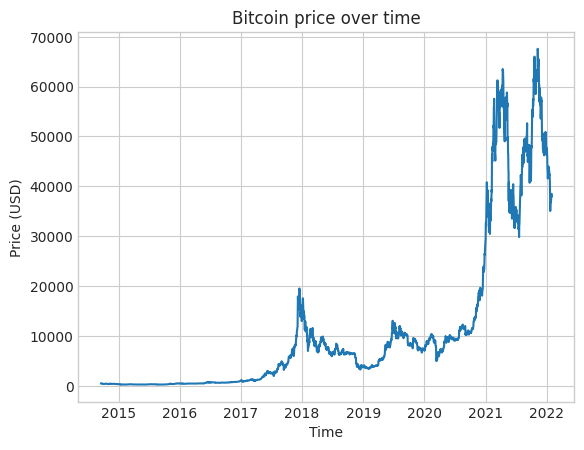

In [6]:
plt.plot(df.Close)
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.title("Bitcoin price over time")
#plt.savefig("initial_plot.png", dpi=250)
plt.show();

In [8]:
X, y = df.drop('Close', axis = 1), df.Close.values
X.shape, y.shape

((2694, 4), (2694,))

스케일링  
타겟을 standard minmax로 ???

In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))

이제 data split 부분이다.  
우리는 현재 날짜까지 100개 샘플을 입력하고, 다음 50스텝의 값을 예측하려고 한다.

In [14]:
def split_sequences(input_sequences, output_sequences, 
                    n_steps_in, n_steps_out
                    ):
    X, y = list(), list()
    for i in range(len(input_sequences)):
        # 입출력의 끝지점을 지정
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out -1
        
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): 
            break
        
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

In [15]:
X_ss, y_mm = split_sequences(
    input_sequences = X_trans, 
    output_sequences= y_trans,
    n_steps_in= 100,
    n_steps_out= 50
    )

print(X_ss.shape, y_mm.shape)

(2546, 100, 4) (2546, 50)


y_mm의 첫 번째 샘플이 실제로 원래 타깃 y 벡터의 100번째 샘플에서 시작되는지 확인해 보겠습니다.

In [19]:
assert y_mm[0].all() == y_trans[99:149].squeeze(1).all()

In [20]:
y_mm[0]

array([0.00209093, 0.00222324, 0.00204426, 0.00206468, 0.00199688,
       0.00196819, 0.00210851, 0.00202031, 0.00203193, 0.00152813,
       0.00127754, 0.00143008, 0.00160392, 0.00172483, 0.00156177,
       0.00166652, 0.00143485, 0.00129928, 0.00133098, 0.00070869,
       0.        , 0.00047101, 0.00044509, 0.00031395, 0.00047836,
       0.00054546, 0.00049284, 0.00072407, 0.00082066, 0.00081284,
       0.00103495, 0.00112207, 0.00141522, 0.00126686, 0.00082821,
       0.00082224, 0.00071706, 0.00058409, 0.00072518, 0.00089223,
       0.00072957, 0.00072341, 0.00057885, 0.00065535, 0.00073678,
       0.00067235, 0.00062335, 0.00061933, 0.00060963, 0.0006479 ])

In [22]:
y_trans[99: 149].squeeze(1)

array([0.00209093, 0.00222324, 0.00204426, 0.00206468, 0.00199688,
       0.00196819, 0.00210851, 0.00202031, 0.00203193, 0.00152813,
       0.00127754, 0.00143008, 0.00160392, 0.00172483, 0.00156177,
       0.00166652, 0.00143485, 0.00129928, 0.00133098, 0.00070869,
       0.        , 0.00047101, 0.00044509, 0.00031395, 0.00047836,
       0.00054546, 0.00049284, 0.00072407, 0.00082066, 0.00081284,
       0.00103495, 0.00112207, 0.00141522, 0.00126686, 0.00082821,
       0.00082224, 0.00071706, 0.00058409, 0.00072518, 0.00089223,
       0.00072957, 0.00072341, 0.00057885, 0.00065535, 0.00073678,
       0.00067235, 0.00062335, 0.00061933, 0.00060963, 0.0006479 ])

위에서 몇 달 후의 데이터를 예측하고 싶다고 언급했습니다. 따라서 95%의 학습 데이터 크기를 사용하고 예측할 나머지 데이터에 5%를 남겨두겠습니다. 이렇게 하면 훈련 세트 크기가 2763일, 즉 약 7년 6개월이 됩니다. 우리는 거의 5개월에 해당하는 145일 후의 미래를 예측할 것입니다.

In [23]:
total_samples = len(X)
train_test_cutoff = round(0.90 * total_samples)
total_samples

2694

In [24]:
X_train = X_ss[:-150]
X_test = X_ss[-150:]

y_train = y_mm[:-150]
y_test = y_mm[-150:] 

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape) 

Training Shape: (2396, 100, 4) (2396, 50)
Testing Shape: (150, 100, 4) (150, 50)


데이터를 텐서로 변환해야 합니다. torch.tensor()를 호출하고 requires_grad=True 속성을 설정하면 됩니다. 일부 오래된 파이토치 튜토리얼에서는 여기에 래퍼 변수를 적용해야 한다고 생각할 수 있습니다. 그러나 이 방법은 더 이상 사용되지 않으며, 이제 포워드 전파할 입력 텐서는 변수로 래핑하지 않고도 자동 역전파(backward()를 통해)가 가능해야 합니다.

In [34]:
from torch.autograd import Variable # 요즘에는 안씀
import torch
import torch.nn as nn
# https://badlec.tistory.com/287

# convert to pytorch tensors
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

In [28]:
X_train_tensors.shape

torch.Size([2396, 100, 4])

In [29]:
# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], 100, 
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], 100, 
                                      X_test_tensors.shape[2])) 

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape: torch.Size([2396, 100, 4]) torch.Size([2396, 50])
Testing Shape: torch.Size([150, 100, 4]) torch.Size([150, 50])


예측할 50개의 값이 테스트 집합의 마지막 50개의 y 값과 일치하는지 확인하려고 합니다.

In [30]:
X_check, y_check = split_sequences(X, y.reshape(-1, 1), 100, 50)
X_check[-1][0:4]

array([[4.99378594e+04, 5.18686797e+04, 4.95385977e+04, 3.03226763e+10],
       [5.17690039e+04, 5.27009414e+04, 5.10536797e+04, 3.88841054e+10],
       [5.26604805e+04, 5.28537656e+04, 4.32852070e+04, 6.52100597e+10],
       [4.68277617e+04, 4.73340547e+04, 4.45613945e+04, 4.90077625e+10]])

In [31]:
X.iloc[-149:-145]

,Open,High,Low,Volume
Date,,,,
2021-09-05,49937.859375,51868.679688,49538.597656,30322676319
2021-09-06,51769.003906,52700.941406,51053.679688,38884105426
2021-09-07,52660.480469,52853.765625,43285.207031,65210059683
2021-09-08,46827.761719,47334.054688,44561.394531,49007762488


In [32]:
y_check[-1]


array([46737.480469, 46612.632813, 48896.722656, 47665.425781,
       46202.144531, 46848.777344, 46707.015625, 46880.277344,
       48936.613281, 48628.511719, 50784.539063, 50822.195313,
       50429.859375, 50809.515625, 50640.417969, 47588.855469,
       46444.710938, 47178.125   , 46306.445313, 47686.8125  ,
       47345.21875 , 46458.117188, 45897.574219, 43569.003906,
       43160.929688, 41557.902344, 41733.941406, 41911.601563,
       41821.261719, 42735.855469, 43949.101563, 42591.570313,
       43099.699219, 43177.398438, 43113.878906, 42250.550781,
       42375.632813, 41744.328125, 40680.417969, 36457.316406,
       35030.25    , 36276.804688, 36654.328125, 36954.003906,
       36852.121094, 37138.234375, 37784.332031, 38138.179688,
       37917.601563, 38483.125   ])

In [33]:
df.Close.values[-50:]

array([46737.480469, 46612.632813, 48896.722656, 47665.425781,
       46202.144531, 46848.777344, 46707.015625, 46880.277344,
       48936.613281, 48628.511719, 50784.539063, 50822.195313,
       50429.859375, 50809.515625, 50640.417969, 47588.855469,
       46444.710938, 47178.125   , 46306.445313, 47686.8125  ,
       47345.21875 , 46458.117188, 45897.574219, 43569.003906,
       43160.929688, 41557.902344, 41733.941406, 41911.601563,
       41821.261719, 42735.855469, 43949.101563, 42591.570313,
       43099.699219, 43177.398438, 43113.878906, 42250.550781,
       42375.632813, 41744.328125, 40680.417969, 36457.316406,
       35030.25    , 36276.804688, 36654.328125, 36954.003906,
       36852.121094, 37138.234375, 37784.332031, 38138.179688,
       37917.601563, 38483.125   ])

LSTM 모델

In [35]:
class LSTM(nn.Module):
    
    def __init__(self,
                 num_classes, input_size, hidden_size, num_layers
                 ):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # num of recurrent layers
        self.input_size = input_size
        self.hidden_size = hidden_size # neurons in each lstm layer
        
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # hidden state
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # cell state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

- num_layers=2로 설정하면 두 개의 LSTM을 함께 쌓아 스택형 LSTM을 형성하고, 두 번째 LSTM은 첫 번째 LSTM의 출력을 받아 최종 결과를 계산하는 것을 의미합니다.

training

In [36]:
def training_loop(
    n_epochs, lstm, 
    optimiser, loss_fn, 
    X_train, y_train, X_test, y_test):
    
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % \
                (epoch, loss.item(), test_loss.item())
                ) 

In [37]:
import warnings
warnings.filterwarnings('ignore')

In [39]:
n_epochs = 1000 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = 4 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = 50 # number of output classes 



In [40]:
lstm = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers)
lstm

LSTM(
  (lstm): LSTM(4, 2, batch_first=True, dropout=0.2)
  (fc_1): Linear(in_features=2, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=50, bias=True)
  (relu): ReLU()
)

In [42]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(lstm.parameters(), lr=learning_rate)

In [43]:

training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimizer,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)

Epoch: 0, train loss: 0.09620, test loss: 0.65934
Epoch: 100, train loss: 0.00492, test loss: 0.01549
Epoch: 200, train loss: 0.00250, test loss: 0.01176
Epoch: 300, train loss: 0.00203, test loss: 0.01503
Epoch: 400, train loss: 0.00189, test loss: 0.01655
Epoch: 500, train loss: 0.00180, test loss: 0.01930
Epoch: 600, train loss: 0.00172, test loss: 0.02137
Epoch: 700, train loss: 0.00164, test loss: 0.02996
Epoch: 800, train loss: 0.00147, test loss: 0.03350
Epoch: 900, train loss: 0.00128, test loss: 0.02970


prediction

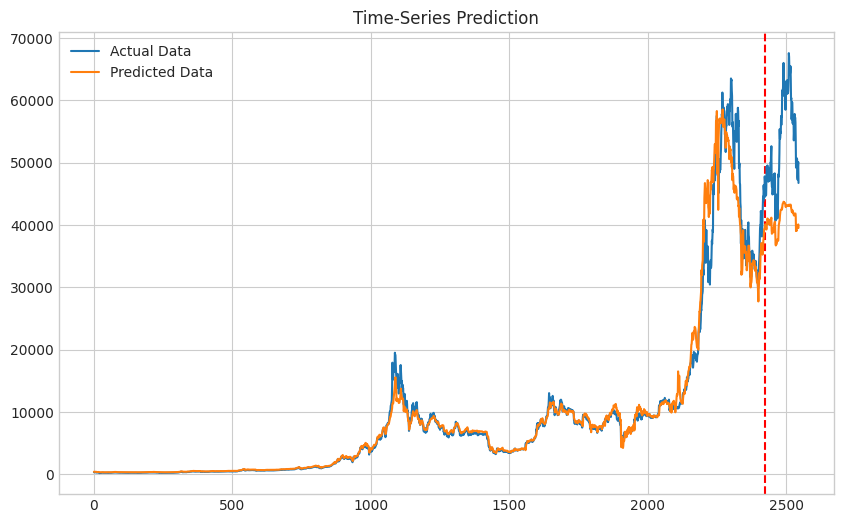

In [44]:
df_X_ss = ss.transform(df.drop(columns=['Close'])) # old transformers
df_y_mm = mm.transform(df.Close.values.reshape(-1, 1)) # old transformers
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 100, 50)
# converting to tensors
df_X_ss = Variable(torch.Tensor(df_X_ss))
df_y_mm = Variable(torch.Tensor(df_y_mm))
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 100, df_X_ss.shape[2]))

train_predict = lstm(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi=300)
plt.show() 

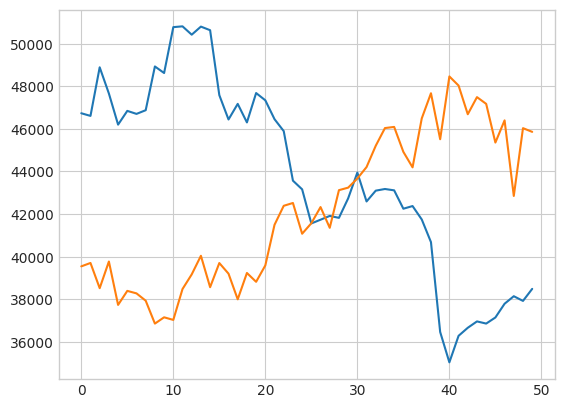

In [45]:
test_predict = lstm(X_test_tensors_final[-1].unsqueeze(0)) # get the last sample
test_predict = test_predict.detach().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

test_target = y_test_tensors[-1].detach().numpy() # last sample again
test_target = mm.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()

plt.plot(test_target, label="Actual Data")
plt.plot(test_predict, label="LSTM Predictions")
plt.savefig("small_plot.png", dpi=300)
plt.show();

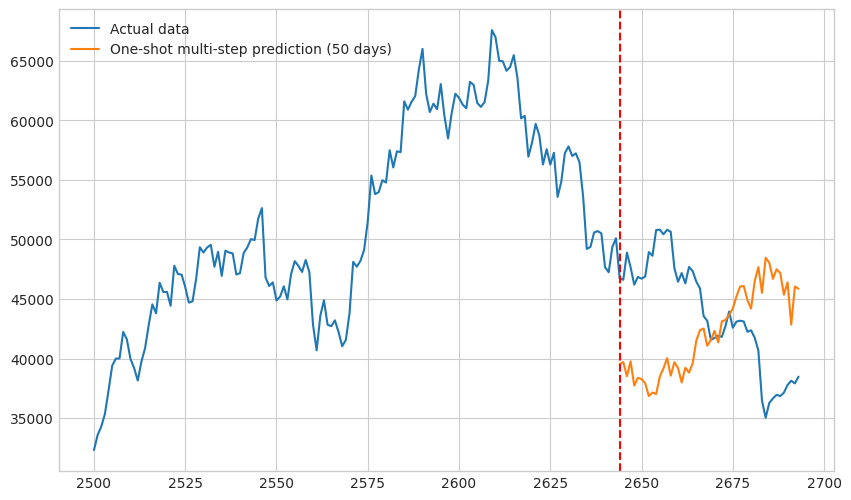

In [46]:
plt.figure(figsize=(10,6)) #plotting
a = [x for x in range(2500, len(y))]
plt.plot(a, y[2500:], label='Actual data');
c = [x for x in range(len(y)-50, len(y))]
plt.plot(c, test_predict, label='One-shot multi-step prediction (50 days)')
plt.axvline(x=len(y)-50, c='r', linestyle='--')
plt.legend()
plt.show()